Notebook containing Gradient Boosting Regressor model

In [32]:
# train defualt GBR model on dataset and get accuracy and error metrics

%store -r X y
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# create a default GBR pipeline with standardised scaling
default_gbr = Pipeline([
    ('scaler', StandardScaler()),
    ('default_gbr', GradientBoostingRegressor())
])

Use GridSearchCV to find optimal hyperparameter tuning for 'n_estimators' and 'learning_rate'

In [33]:
from sklearn.model_selection import KFold, cross_validate
import numpy as np

scoring = {
    "neg_mse": "neg_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "r2": "r2"
}

ten_fold_cv = KFold(n_splits=10, shuffle=True, random_state=42)

default_cv = cross_validate(
    default_gbr, 
    X, y, 
    cv=ten_fold_cv, 
    scoring=scoring, 
    return_train_score=True
)

print(default_cv.keys())

# evaulate default gbr models performance - get mean over 10 folds

# domain dependent metrics
train_mse = -default_cv["train_neg_mse"]
train_rmse = np.sqrt(train_mse).mean()              
train_mae = -default_cv["train_neg_mae"].mean()
# domain independent metric 
train_r2  = default_cv["train_r2"].mean()           

test_mse  = -default_cv["test_neg_mse"]
test_rmse = np.sqrt(test_mse).mean()
test_mae  = -default_cv["test_neg_mae"].mean()

test_r2   = default_cv["test_r2"].mean()

print(f"Default GBR Model Performance over 10-Fold CV:\n")
print(f"Train RMSE:   ", train_rmse)
print(f"Train MAE:   ", train_mae)
print(f"Train R2:   ", train_r2)

print(f"\nTest RMSE:   ", test_rmse)
print(f"Test MAE:   ", test_mae)
print(f"Test R2:   ", test_r2)  

dict_keys(['fit_time', 'score_time', 'test_neg_mse', 'train_neg_mse', 'test_neg_mae', 'train_neg_mae', 'test_r2', 'train_r2'])
Default GBR Model Performance over 10-Fold CV:

Train RMSE:    16.945710086131907
Train MAE:    12.622180622345976
Train R2:    0.9653067020167405

Test RMSE:    27.543723779236682
Test MAE:    20.090815627157575
Test R2:    0.9017691823375351


In [34]:
from sklearn.model_selection import GridSearchCV

# create pipeline for gridsearching
grid_gbr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tuned_gbr', GradientBoostingRegressor())
])

# enter range of hp's to be checked
param_grid = {
    'tuned_gbr__n_estimators': [100, 200, 300, 400],
    'tuned_gbr__learning_rate': [0.01, 0.1, .2, 0.3, 0.4, 0.5]
}

gridsearch_gbr = GridSearchCV(grid_gbr_pipeline, param_grid, cv=10, scoring='neg_mean_squared_error')
gridsearch_gbr.fit(X, y)

best_params = gridsearch_gbr.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'tuned_gbr__learning_rate': 0.1, 'tuned_gbr__n_estimators': 400}


In [35]:
# create new pipeline with best performing hp's from gridsearch
improved_gbr = Pipeline([
    ('scaler', StandardScaler()),
    ('improved_gbr', GradientBoostingRegressor(learning_rate=0.1, n_estimators=300))
])

# reproduce 10-fold cv across dataset with improved hp's
ten_fold_cv = KFold(n_splits=10, shuffle=True, random_state=42)

improved_cv = cross_validate(
    improved_gbr, 
    X, y, 
    cv=ten_fold_cv, 
    scoring=scoring, 
    return_train_score=True
)

# evaluate improved hp's error/accuracy metrics from train and test runs
improved_train_mse = -improved_cv["train_neg_mse"]
improved_train_rmse = np.sqrt(improved_train_mse).mean()              
improved_train_mae = -improved_cv["train_neg_mae"].mean()

improved_train_r2  = improved_cv["train_r2"].mean()

improved_test_mse  = -improved_cv["test_neg_mse"]
improved_test_rmse = np.sqrt(improved_test_mse).mean()
improved_test_mae  = -improved_cv["test_neg_mae"].mean()

improved_test_r2   = improved_cv["test_r2"].mean()

# print metrics
print(f"Improved GBR Model Performance over 10-Fold CV:\n")
print(f"Mean Train RMSE: ", improved_train_rmse)
print(f"Mean Train MAE: ",  improved_train_mae)
print(f"Mean Train R2: ",   improved_train_r2)
print(f"\nMean Test RMSE: ",  improved_test_rmse)
print(f"Mean Test MAE: ",   improved_test_mae)
print(f"Mean Test R2: ",   improved_test_r2)

Improved GBR Model Performance over 10-Fold CV:

Mean Train RMSE:  8.943324078856346
Mean Train MAE:  6.546361393376083
Mean Train R2:  0.9903163058383235

Mean Test RMSE:  25.23951508620195
Mean Test MAE:  17.896462566574364
Mean Test R2:  0.9178662297766245


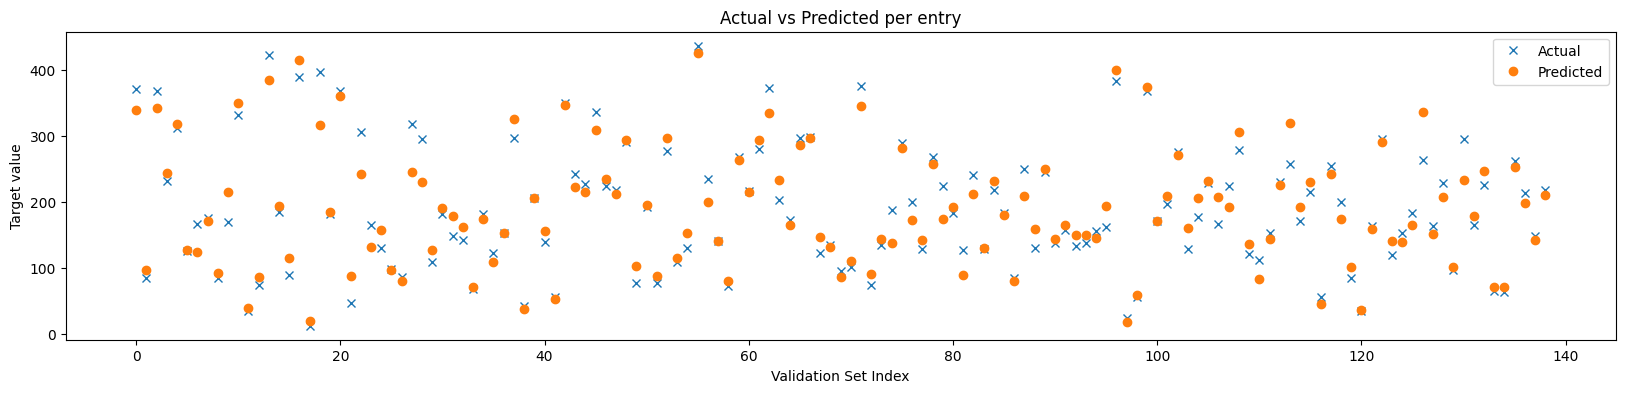

In [36]:
# create scatter plot to compare predictions to actual tensile stength over a given run (optimal hp's)
from sklearn.model_selection import train_test_split
import numpy as np, matplotlib.pyplot as plt

# new instance of gbr
graph_gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=300)

# split the dataset into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

graph_gbr.fit(X_train, y_train)

y_val_prediction = graph_gbr.predict(X_val)     # predict values for validation set given training set

# store each prediction data entry in index for visualisation
index = np.arange(len(y_val))

plt.figure(figsize=(20, 4))
# plot acc vs pred
plt.plot(index, y_val, 'x', label='Actual')
plt.plot(index, y_val_prediction, 'o', label='Predicted')
plt.xlabel("Validation Set Index")
plt.ylabel("Target value")
plt.title("Actual vs Predicted per entry")
plt.legend()
plt.show()

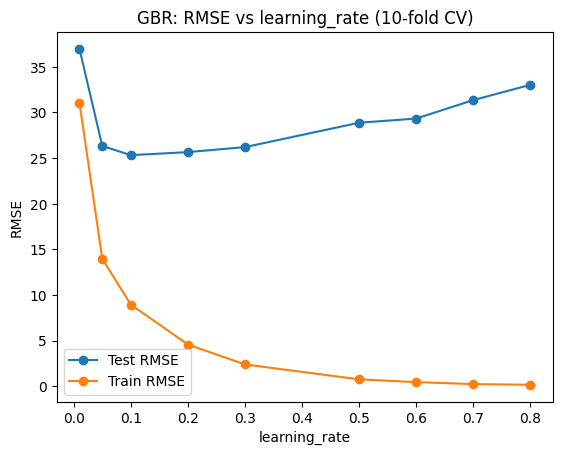

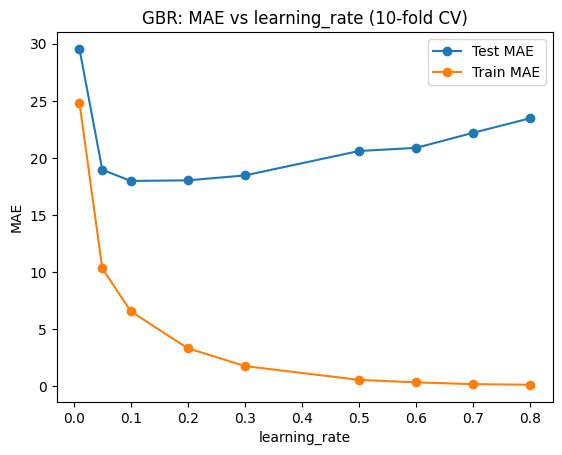

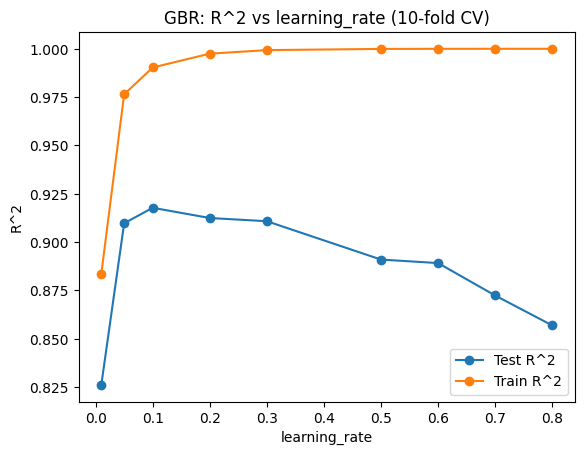

In [37]:
# graph out learning rate error metrics/accuracy through cv ranges
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# get learning rate across range of values
learning_r  = "improved_gbr__learning_rate"
param_range = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]


# root mean squared error (using negative mse) - validation curve
train_mse, test_mse = validation_curve(
    improved_gbr, 
    X, y,
    param_name=learning_r, 
    param_range=param_range,
    scoring="neg_mean_squared_error", 
    cv=ten_fold_cv
)
# convert to rmse
train_rmse = np.sqrt(-train_mse)
test_rmse  = np.sqrt(-test_mse)

# plot figures
plt.figure()
plt.plot(param_range, test_rmse.mean(axis=1), marker="o", label="Test RMSE")        # plot mean rmse across folds (test)
plt.plot(param_range, train_rmse.mean(axis=1), marker="o", label="Train RMSE")      # plot mean rmse across folds (train)
plt.xlabel("learning_rate"); 
plt.ylabel("RMSE")
plt.title("GBR: RMSE vs learning_rate (10-fold CV)")
plt.legend(); 
plt.show()

# mean absolute error
train_mae_s, test_mae_s = validation_curve(
    improved_gbr, 
    X, y,
    param_name=learning_r, 
    param_range=param_range,
    scoring="neg_mean_absolute_error", 
    cv=ten_fold_cv
)
# convert values to postive
train_mae = -train_mae_s
test_mae  = -test_mae_s

# plot results
plt.figure()
plt.plot(param_range, test_mae.mean(axis=1), marker="o", label="Test MAE")
plt.plot(param_range, train_mae.mean(axis=1), marker="o", label="Train MAE")
plt.xlabel("learning_rate"); 
plt.ylabel("MAE")
plt.title("GBR: MAE vs learning_rate (10-fold CV)")
plt.legend(); 
plt.show()

# sum of squared errors
train_r2, test_r2 = validation_curve(
    improved_gbr, 
    X, y,
    param_name=learning_r, 
    param_range=param_range,
    scoring="r2", 
    cv=ten_fold_cv
)

# plot metrics
plt.figure()
plt.plot(param_range, test_r2.mean(axis=1), marker="o", label="Test R^2")
plt.plot(param_range, train_r2.mean(axis=1), marker="o", label="Train R^2")
plt.xlabel("learning_rate"); 
plt.ylabel("R^2")
plt.title("GBR: R^2 vs learning_rate (10-fold CV)")
plt.legend(); 
plt.show()



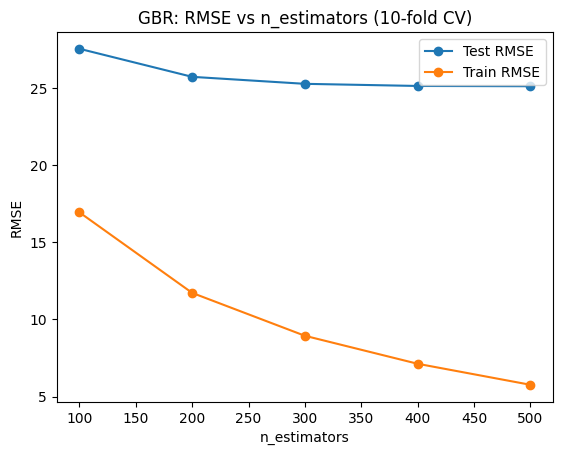

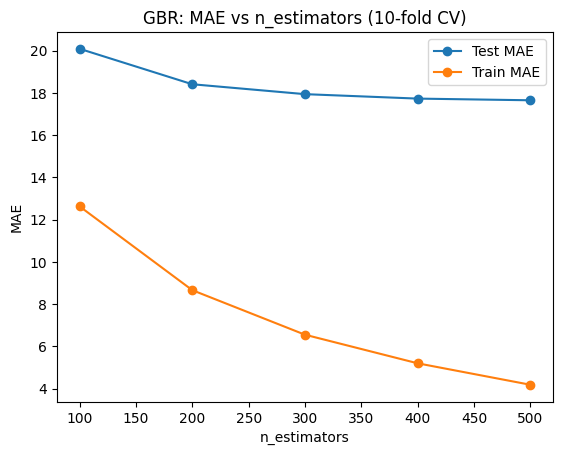

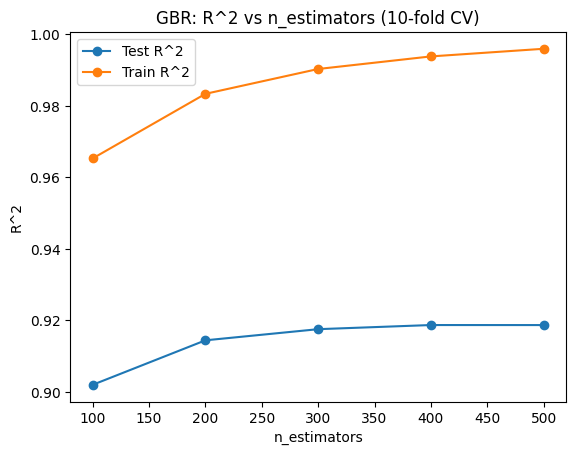

In [38]:
# repeat graphing for n_estimators
n_estimators  = "improved_gbr__n_estimators"
param_range_estimators = [100, 200, 300, 400, 500]


train_mse, test_mse = validation_curve(
    improved_gbr, 
    X, y,
    param_name=n_estimators, 
    param_range=param_range_estimators,
    scoring="neg_mean_squared_error", 
    cv=ten_fold_cv
)
train_rmse = np.sqrt(-train_mse)
test_rmse  = np.sqrt(-test_mse)

plt.figure()
plt.plot(param_range_estimators, test_rmse.mean(axis=1), marker="o", label="Test RMSE")
plt.plot(param_range_estimators, train_rmse.mean(axis=1), marker="o", label="Train RMSE")
plt.xlabel("n_estimators"); 
plt.ylabel("RMSE")
plt.title("GBR: RMSE vs n_estimators (10-fold CV)")
plt.legend(); 
plt.show()


train_mae_g, test_mae_g = validation_curve(
    improved_gbr, 
    X, y,
    param_name=n_estimators,
    param_range=param_range_estimators,
    scoring="neg_mean_absolute_error", 
    cv=ten_fold_cv
)
train_mae = -train_mae_g
test_mae  = -test_mae_g

plt.figure()
plt.plot(param_range_estimators, test_mae.mean(axis=1), marker="o", label="Test MAE")
plt.plot(param_range_estimators, train_mae.mean(axis=1), marker="o", label="Train MAE")
plt.xlabel("n_estimators"); 
plt.ylabel("MAE")
plt.title("GBR: MAE vs n_estimators (10-fold CV)")
plt.legend(); 
plt.show()


train_r2, test_r2 = validation_curve(
    improved_gbr, 
    X, y,
    param_name=n_estimators, 
    param_range=param_range_estimators,
    scoring="r2", 
    cv=ten_fold_cv
)

plt.figure()
plt.plot(param_range_estimators, test_r2.mean(axis=1), marker="o", label="Test R^2")
plt.plot(param_range_estimators, train_r2.mean(axis=1), marker="o", label="Train R^2")
plt.xlabel("n_estimators"); 
plt.ylabel("R^2")
plt.title("GBR: R^2 vs n_estimators (10-fold CV)")
plt.legend(); 
plt.show()
